In [221]:
import numpy as np
import pandas as pd
import cvxpy as cp
from data_collection import *

# Cleaning and Setup

In [222]:
assets = pd.read_csv('Notes&Bonds_raw.csv')
assets.MATURITY = pd.to_datetime(assets.MATURITY)

# Keep only bonds mature at June or Dec, before 2028
# Keep May and Nov in 2028 as 2028 does not have
assets = assets[(((assets.MATURITY.dt.month % 6 == 0)) & (assets.MATURITY.dt.year < 2028))
                | ((assets.MATURITY.dt.year == 2028) & (assets.MATURITY.dt.month == 5))]

print("Number of bond assets: ", len(assets))

# Use mean of BID and ASK as prices
assets['PRICE'] = (assets.BID + assets.ASKED) / 2
assets = assets[['MATURITY', 'COUPON', 'PRICE']]
assets.MATURITY = assets.MATURITY.dt.strftime('%Y%m')

# Hard code May 2028 and Nov 2028 as June and Dec
assets.loc[assets.MATURITY == '202805', 'MATURITY'] = '202806'

# Mapping year-month to period 0 to 16
# 0: 202006, 1: 202012, ... 16: 202806
dates = [str(y) + m for y in list(range(2020,2029)) for m in ['06', '12']]
period = list(range(len(dates)))
datemap = dict(zip(dates, period))
assets.MATURITY = assets.MATURITY.map(datemap)

display(assets)

def transform(x):
    cashflow = [0] * 16
    for i in range(x.MATURITY.astype('int')):
        if i != x.MATURITY.astype('int') - 1:
            cashflow[i] = x.COUPON / 2
        else:
            cashflow[i] = 100 + x.COUPON / 2
    return pd.Series(cashflow, index=list(range(1,17)))

n = 34 # number of assets
m = 16 # number of payment periods

# Construct bond payoff matrix (F matrix)
F = assets.apply(lambda x: transform(x), axis=1)
display(F)
F = F.values.T

# Liabilities
L = np.array([11, 9, 7, 9, 9, 12, 8, 10, 
     6,  5, 7, 7, 8,  7, 9,  9,])

R = -np.identity(m)
R[1:m,0:m-1] = R[1:m,0:m-1]+np.identity(m-1)

p = np.array(assets.PRICE)




Number of bond assets:  34


,MATURITY,COUPON,PRICE
13,1,1.875,100.154
14,1,1.750,100.159
15,1,2.375,100.219
16,1,2.500,100.232
39,2,2.625,101.289
40,2,1.125,100.254
41,2,1.625,101.064
42,2,2.125,101.192
67,3,2.625,103.044
68,3,1.625,101.299


,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
13,100.9375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
14,100.8750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
15,101.1875,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
16,101.2500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
39,1.3125,101.3125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
40,0.5625,100.5625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
41,0.8125,100.8125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
42,1.0625,101.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
67,1.3125,1.3125,101.3125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
68,0.8125,0.8125,100.8125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


# Q3

In [223]:
# cvxpy problem setup and solution
x = cp.Variable(n)
s = cp.Variable(m)
prob = cp.Problem(cp.Minimize(p.T@x),
                 [F@x + R@s == L, x>=0, s>=0])
prob.solve() 

# Recall that cvxpy yields shadow prices with flipped sign
shadowprices = -prob.constraints[0].dual_value
impliedrates = 1/(shadowprices**(1/np.array(range(1,17))))-1

# Print result.
print("\nThe optimal value is", prob.value)
print("\nPortfolio x:")
# print(x.value)
# For better presentation
for i in x.value:
	print("{:.3f}".format(i))
print("\nSurplus s:")
print(s.value)
print("\nImplied rates:")
print(impliedrates)


The optimal value is 130.1633078850558

Portfolio x:
-0.000
-0.000
-0.000
0.097
0.152
-0.000
-0.000
-0.000
0.000
0.000
0.000
0.000
0.128
-0.000
-0.000
-0.000
-0.000
0.020
-0.000
-0.000
0.112
0.073
-0.000
0.000
0.094
-0.000
0.055
-0.000
0.102
0.010
0.067
0.078
0.157
0.089

Surplus s:
[ 4.08295516e-06  7.36313468e+00  1.35916766e+00  6.12920460e+00
  9.09079594e-07 -4.08503200e-06  1.72831365e-04 -1.74932126e-04
 -6.95550925e-07  5.64104189e+00  5.98178983e-07  3.01503542e-07
  8.77236788e-07  8.87245057e+00 -7.68780116e-06  2.17688221e-06]

Implied rates:
[0.01015596 0.00659631 0.0046085  0.00301217 0.00216686 0.00250564
 0.00218352 0.00207515 0.00201067 0.00231221 0.00200143 0.00241349
 0.00240436 0.00244102 0.00227811 0.00340467]


# Q4

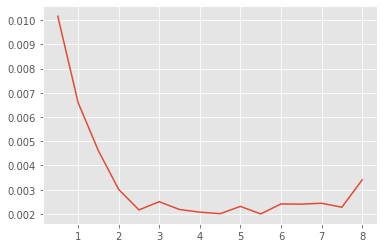

In [224]:
pd.Series(impliedrates, index=0.5 * np.array(range(1, 17))).plot()

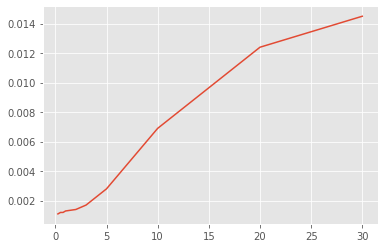

In [225]:
term_struct_trea.plot()

# Q4

In [226]:
corporate = pd.read_csv('Corporate_raw.csv').iloc[:,1:]
corporate

,Price,Coupon,Maturity
0,104.77,2.65%,2022/11/3
1,145.19,5.20%,2039/6/1
2,149.51,5.30%,2041/2/8
3,110.34,4.95%,2033/5/15
4,127.05,6.73%,2023/11/15


In [227]:
datemap

{'202006': 0,
 '202012': 1,
 '202106': 2,
 '202112': 3,
 '202206': 4,
 '202212': 5,
 '202306': 6,
 '202312': 7,
 '202406': 8,
 '202412': 9,
 '202506': 10,
 '202512': 11,
 '202606': 12,
 '202612': 13,
 '202706': 14,
 '202712': 15,
 '202806': 16,
 '202812': 17}

In [229]:
# Filter out bonds with maturity after 2028 as we have no cashflow needs after that
# Hard code the newly added corporate bond
# 202211: 5
# 202311: 7
assets2 = assets.copy()
assets2 = assets2.append(pd.Series([5, 2.65, 104.77], index=assets.columns), ignore_index=True)
assets2 = assets2.append(pd.Series([7, 6.73, 127.05], index=assets.columns), ignore_index=True)
assets2.sort_values(by='MATURITY', inplace=True)

def transform(x):
    cashflow = [0] * 16
    for i in range(x.MATURITY.astype('int')):
        if i != x.MATURITY.astype('int') - 1:
            cashflow[i] = x.COUPON / 2
        else:
            cashflow[i] = 100 + x.COUPON / 2
    return pd.Series(cashflow, index=list(range(1,17)))

n = 34 + 2 # number of assets
m = 16 # number of payment periods

# Construct bond payoff matrix (F matrix)
F = assets2.apply(lambda x: transform(x), axis=1)
display(F)
F = F.values.T

# Liabilities
L = np.array([11, 9, 7, 9, 9, 12, 8, 10, 
     6,  5, 7, 7, 8,  7, 9,  9,])

R = -np.identity(m)
R[1:m,0:m-1] = R[1:m,0:m-1]+np.identity(m-1)

p = np.array(assets2.PRICE)

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,100.9375,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,100.8750,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,101.1875,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,101.2500,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,1.3125,101.3125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
5,0.5625,100.5625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,0.8125,100.8125,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
7,1.0625,101.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
11,1.0625,1.0625,101.0625,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
10,1.0000,1.0000,101.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


In [231]:
# cvxpy problem setup and solution
x = cp.Variable(n)
s = cp.Variable(m)
prob = cp.Problem(cp.Minimize(p.T@x),
                 [F@x + R@s == L, x>=0, s>=0])
prob.solve() 

# Recall that cvxpy yields shadow prices with flipped sign
shadowprices = -prob.constraints[0].dual_value
impliedrates = 1/(shadowprices**(1/np.array(range(1,17))))-1

# Print result.
print("\nThe optimal value is", prob.value)
print("\nPortfolio x:")
# print(x.value)
# For better presentation
for i in x.value:
	print("{:.3f}".format(i))
print("\nSurplus s:")
print(s.value)
print("\nImplied rates:")
print(impliedrates)


The optimal value is 130.1709127284358

Portfolio x:
0.000
0.000
0.000
0.097
0.086
-0.000
-0.000
-0.000
0.000
0.000
0.000
0.053
-0.000
0.080
-0.000
-0.000
0.091
0.000
0.000
0.000
0.000
0.102
-0.000
0.073
-0.000
0.045
0.050
0.000
0.055
0.000
0.050
0.062
0.067
0.078
0.179
0.067

Surplus s:
[-1.43620280e-05  6.94976445e-01 -2.62593154e-05  1.59904801e-05
  1.03042652e+00  3.84434240e-03  3.79773739e-06  8.69660223e-07
  4.23238889e-06  4.03291935e-01 -3.08666844e-08 -4.17069991e-08
  1.02519335e-07  1.10850203e+01  2.18164514e+00  1.74255041e-07]

Implied rates:
[0.0100731  0.00658424 0.00373641 0.00304427 0.00357333 0.00250153
 0.00217599 0.00206934 0.00200542 0.00230648 0.00199653 0.00241032
 0.00240165 0.00244738 0.00294906 0.00338566]


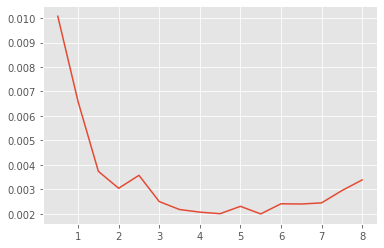

In [232]:
pd.Series(impliedrates, index=0.5 * np.array(range(1, 17))).plot()

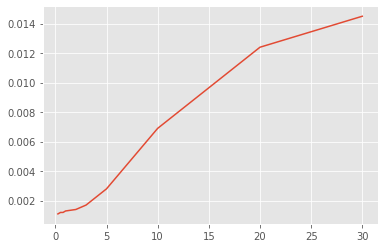

In [233]:
term_struct_trea.plot()